In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [272]:
def preprocess_data():
    """ 
    Extract necessary rows and columns 
    """
    input_df = pd.read_csv("datasets/world-development-indicators-ng.csv")
    input_df = input_df.T  # Transpose the data
    input_df = input_df.iloc[4:, [0, 30]]  # Extract necessary rows and columns
    input_df = input_df.reset_index()
    input_df.columns = ["Year", "Population", "GDP($)"]
    input_df["Year"] = input_df["Year"].str.extract(r"(\d{4})")  # extract 4 digits
    input_df["Year"] = input_df["Year"].astype(int)

    input_df["GDP($)"] = input_df["GDP($)"].astype(float)
    input_df["GDP($)"] = input_df["GDP($)"] / 1000000000

    input_df["Population"] = input_df["Population"].astype(float)
    input_df["Population"] = input_df["Population"] / 1000000  # convert to millions

    return input_df


df = preprocess_data()

In [273]:
df.describe()

,Year,Population,GDP($)
count,64.000000,64.000000,64.000000
mean,1991.500000,110.784107,160.300712
std,18.618987,52.880398,170.706076
min,1960.000000,44.928342,4.196175
25%,1975.750000,64.206564,33.971289
50%,1991.500000,98.933703,73.521100
75%,2007.250000,149.316147,282.447844
max,2023.000000,223.804632,574.183763


In [274]:
df.corr()

,Year,Population,GDP($)
Year,1.000000,0.977232,0.866862
Population,0.977232,1.000000,0.914796
GDP($),0.866862,0.914796,1.000000


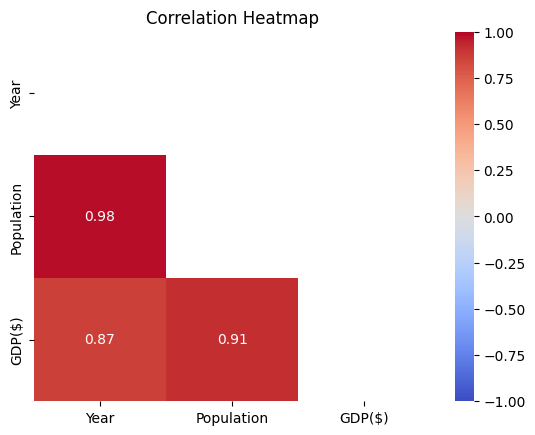

In [275]:
fig, ax = plt.subplots()
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), ax=ax, vmin=-1, vmax=1, cmap="coolwarm", annot=True, mask=mask)
plt.title("Correlation Heatmap")
plt.show()

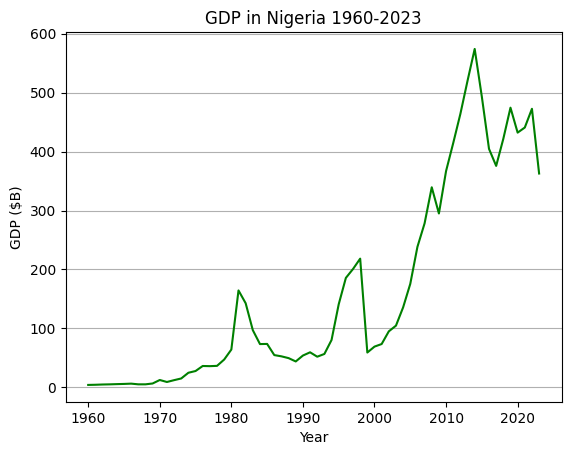

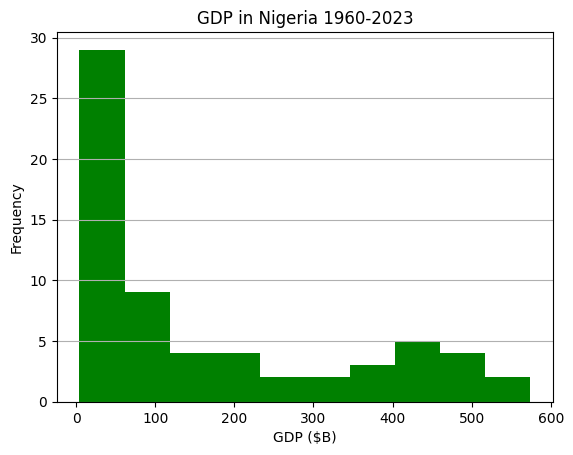

In [276]:
def line_plot_gdp():
    """Line Plot of the GDP"""
    plt.plot(df["Year"], df["GDP($)"], color="green", label="GDP")
    plt.title("GDP in Nigeria 1960-2023")
    plt.xlabel("Year")
    plt.ylabel("GDP ($B)")
    plt.grid(axis="y")
    plt.show()


def hist_plot_gdp():
    """Histogram of the GDP"""
    plt.hist(df["GDP($)"], bins=10, color="green", label="GDP")
    plt.title("GDP in Nigeria 1960-2023")
    plt.xlabel("GDP ($B)")
    plt.ylabel("Frequency")
    plt.grid(axis="y")


line_plot_gdp()
hist_plot_gdp()

In [277]:
def linfunc(x, a, b):
    """
    Function for fitting a straight line, for curve_fit
    x: independent variable
    a, b: parameters to be fitted
    """
    y = a * x + b
    return y


def exponential_fit(x, a, b):
    """
    Calculates exponential function with scale factor a and growth rate b.
    """
    f = a * np.exp(b * x)
    return f


def logistic_fit(t, a, b, t0):
    """
    Calculates the logistic function with scale factor a and growth rate b
    """
    f = a / (1 + np.exp(-b * (t - t0)))
    return f

In [278]:
x = (df["Year"] - 1960).values  # normalize timeframe
y = df["GDP($)"]

# Linear Fit
p, cov = curve_fit(linfunc, x, y)
sigma = np.sqrt(np.diag(cov))  # errors

y_linear_pred = linfunc(x, *p)
df["Linear Fit"] = y_linear_pred

# Exponential fit
p, cov = curve_fit(exponential_fit, x, y, p0=(1, 0.01))
sigma_exp = np.sqrt(np.diag(cov))

y_exp_pred = exponential_fit(x, *p)
df["Exp. Fit"] = y_exp_pred

# Logistic Fit
p, cov = curve_fit(logistic_fit, x, y, p0=(1.2e12, 0.3, 10))
sigma_log = np.sqrt(np.diag(cov))

y_log_pred = logistic_fit(x, *p)
df["Log. Fit"] = y_log_pred

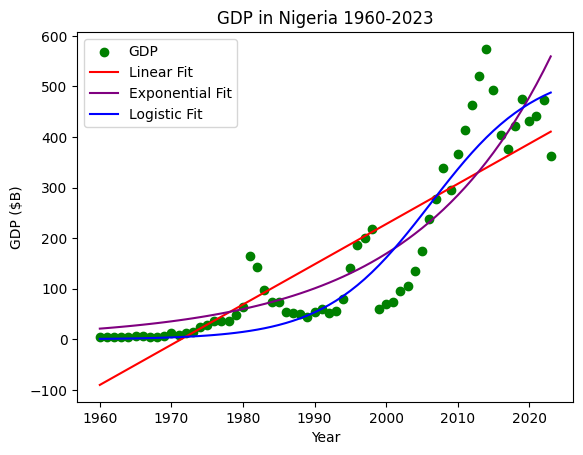

In [279]:
def plot_fitted():
    """
    Plot scatter plot and fitted lines
    """
    plt.scatter(df["Year"], df["GDP($)"], color="green", label="GDP")
    plt.plot(df["Year"], df["Linear Fit"], color="red", label="Linear Fit")
    plt.plot(df["Year"], df["Exp. Fit"], color="purple", label="Exponential Fit")
    plt.plot(df["Year"], df["Log. Fit"], color="blue", label="Logistic Fit")
    plt.title("GDP in Nigeria 1960-2023")
    plt.xlabel("Year")
    plt.ylabel("GDP ($B)")

    plt.legend()
    plt.show()


plot_fitted()

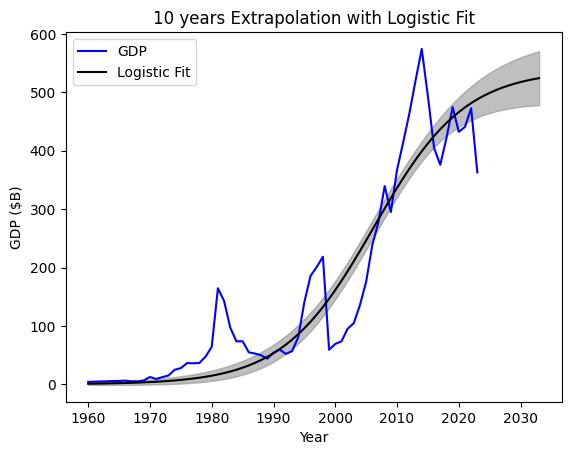

In [280]:
## Extrapolating into the next 10 years

sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=1000)
# determine predictions for each of those times

time_predictions = np.arange(1960, 2034)
gdp_predictions = logistic_fit(time_predictions - 1960, *p)

# find uncertainty at each prediction
gdp_uncertainties = [
    np.std(logistic_fit(future_time - 1960, *sample_params.T))
    for future_time in time_predictions
]


def extrapolate_logistic_fit():
    """
    Extrapolate data using Logistic fit
    """
    _, ax = plt.subplots()
    ax.plot(df["Year"], df["GDP($)"], "b-", label="GDP")

    ax.plot(time_predictions, gdp_predictions, "k-", label="Logistic Fit")

    ax.fill_between(
        time_predictions,
        gdp_predictions - gdp_uncertainties,
        gdp_predictions + gdp_uncertainties,
        color="gray",
        alpha=0.5,
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("GDP ($B)")
    ax.legend()
    plt.title("10 years Extrapolation with Logistic Fit")
    plt.show()


extrapolate_logistic_fit()

In [281]:
## Clustering


xy = df[["Year", "GDP($)"]].copy()
scaler = StandardScaler()
norm = scaler.fit_transform(xy)

def one_silhoutte_inertia(n, xy):
    """
    Calculates the silhoutte score and WCSS for n clusters
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters=n, n_init=20)
    # Fit the data
    kmeans.fit(xy)
    labels = kmeans.labels_
    # calculate the silhoutte score
    score = silhouette_score(xy, labels)
    inertia = kmeans.inertia_
    return score, inertia


wcss = []
best_n, best_score = None, -np.inf
for n in range(2, 11):  # 2 to 10 clusters
    score, inertia = one_silhoutte_inertia(n, norm)
    wcss.append(inertia)
    if score > best_score:
        best_n = n
        best_score = score


print(f"Best number of clusters = {best_n:2g} with score of {best_score:0.2f}")

Best number of clusters =  2 with score of 0.64


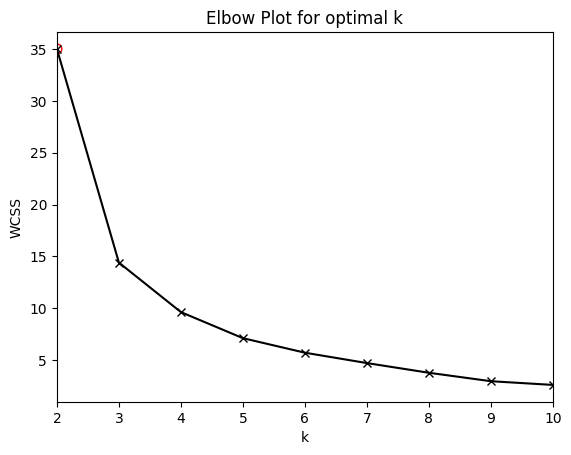

In [282]:
def plot_elbow_method(min_k, max_k, wcss, best_n):
    """
    Plots the elbow method between min_k and max_k
    """
    _, ax = plt.subplots()
    ax.plot(range(min_k, max_k + 1), wcss, "kx-")
    ax.scatter(
        best_n, wcss[best_n - min_k], marker="o", color="red", facecolors="none", s=50
    )
    ax.set_xlabel("k")
    ax.set_xlim(min_k, max_k)
    ax.set_ylabel("WCSS")
    plt.title("Elbow Plot for optimal k")
    plt.show()

plot_elbow_method(2, 10, wcss, best_n)

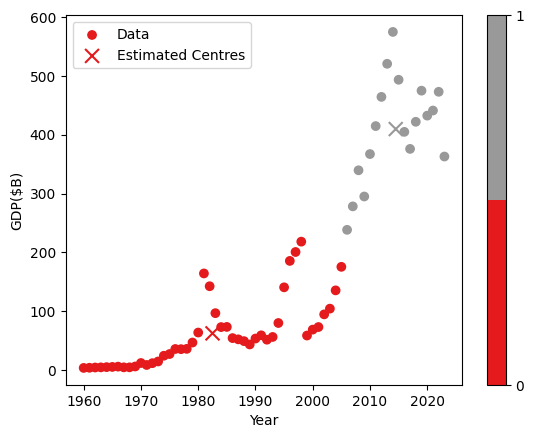

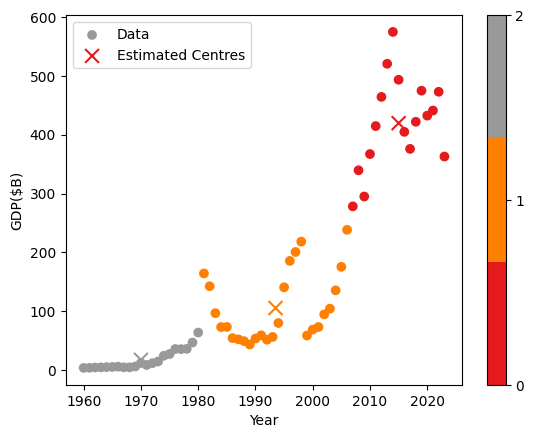

In [283]:

def plot_fitted_year_gdp(labels, xy, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)
    _, ax = plt.subplots()

    s = ax.scatter(xy[:, 0], xy[:, 1], c=labels, cmap=cmap, marker="o", label="Data")
    ax.scatter(
        xkmeans,
        ykmeans,
        c=centre_labels,
        cmap=cmap,
        marker="x",
        s=100,
        label="Estimated Centres",
    )
    cbar = fig.colorbar(s, ax=ax)
    cbar.set_ticks(np.unique(labels))
    ax.legend()
    ax.set_xlabel("Year")
    ax.set_ylabel("GDP($B)")
    plt.show()

inv_norm = scaler.inverse_transform(norm)
for k in range(2, 4):
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(norm)  # fit done on x,y pairs
    labels = kmeans.labels_

    # the estimated cluster centres
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    plot_fitted_year_gdp(labels, inv_norm, xkmeans, ykmeans, cenlabels)